In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt

import rasterio
from osgeo import gdal, ogr, osr
from gdalconst import *
gdal.UseExceptions()

from datetime import datetime

import stac

## Obter imagens da área de interesse via STAC (BrazilDataCube)

In [2]:
# Criar conexão com o servidor da STAC
bdc_stac_service = stac.STAC('http://brazildatacube.dpi.inpe.br/')

# Obter itens filtrados pelo objeto JSON (https://stacspec.org/STAC-api.html#operation/postSearchSTAC)
# Filtro: 200 primeiras imagens da coleção 'LC8SR-1' que intersectam o ponto -46.872, -17.150 ("centroide" de paracatu).
item = bdc_stac_service.search({'collections':['LC8SR-1'], 
                                "intersects": {"type": "Point",
                                               "coordinates": [-46.872, -17.150]},
                                'limit': 200})

# Mostrar quantas imagens foram recuperadas
len(item.features)

93

## Criar um dicionário com as datas e links das imagens

In [3]:
links = {}

# Percorrer todos o itens obtidos da STAC
for i in item.features:
    
    # Adquirir a data da imagem
    date = i['properties']['datetime'][0:10]
    
    # Inserir um item no dicionário 'links' com (chave = data da imagem) e (valor = URL da imagem).
    # IV selecionado: NDVI
    links[date] = {'ndvi':i['assets']['sr_ndvi']['href'], 'fmask':i['assets']['Fmask4']['href']}

## Abrir arquivo de pontos e extrair coordenadas

In [4]:
# Abrir arquivo de pontos
df = gpd.read_file('./DADOS/pt_ref_23n.geojson')

# Gerar duas listas (lat e lon) com as coordenadas dos pontos
lat = []
lon = []
for i in df.geometry:
    lon.append(i.x)
    lat.append(i.y)

## Amostrar os valores das imagens para os pontos de referência

### NDVI

In [5]:
# Para evitar a execução total dessa célula, salvei o resultado dela (dicionário) em um arquivo. 
# Caso o arquivo seja encontrado, o processamento é evitado
try:
    out = np.load('./DADOS/out_ref.npy', allow_pickle=True).item()
    print("Arquivo aberto com sucesso!")
except:
    print("Arquivo não encontrado, amostrando pontos pela série de imagens...")
    
    # Criar um dicionário de saída
    out = {}
    # Percorrer todas os pares data(k)/URL(v) da lista 'links'
    for k,v in links.items():
        # Abrir a imagem da URL
        with rasterio.open(v['ndvi']) as src:
            # Obter o valores dos pixel da imagem para as coordenadas dos pontos (amostrar valores)
            val = [x[0] for x in src.sample(zip(lon,lat))]

            # Inserir o item no dicionário 'out' com (chave = data da imagem) e (valor = lista de valores da imagem).
            out[k] = val
                    
    print("Amostragem finalizada!")
    
    try:
        np.save('./DADOS/out_ref.npy', out)
        print('O resultado foi salvo')
    except:
        print('O resultado não foi salvo')

Arquivo aberto com sucesso!


In [6]:
# Inserir os valores obtidos como colunas no dataframe dos pontos
for k,v in out.items():
    df.insert(loc=2,column=datetime.strptime(k,'%Y-%m-%d'), value=v)
    
df.drop(['operador','geometry','Name'],1, inplace=True)
df.rename(columns={'id': 'date'}, inplace=True)
df = df.set_index('date').T/10000

### Cloud mask

In [7]:
try:
    mask = np.load('./DADOS/out_ref_mask.npy', allow_pickle=True).item()
    print("Arquivo aberto com sucesso!")
except:
    print("Arquivo não encontrado, amostrando pontos pela série de imagens...")
    
    # Criar um dicionário de saída
    mask = {}
    # Percorrer todas os pares data(k)/URL(v) da lista 'links'
    for k,v in links.items():
        # Abrir a imagem da URL
        with rasterio.open(v['fmask']) as src:
            # Obter o valores dos pixel da imagem para as coordenadas dos pontos (amostrar valores)
            val = [x[0] for x in src.sample(zip(lon,lat))]

            # Inserir o item no dicionário 'out' com (chave = data da imagem) e (valor = lista de valores da imagem).
            mask[k] = val
                    
    print("Amostragem finalizada!")
    
    try:
        np.save('./DADOS/out_ref_mask.npy', mask)
        print('O resultado foi salvo')
    except:
        print('O resultado não foi salvo')

Arquivo aberto com sucesso!


In [8]:
df_mask = gpd.read_file('./DADOS/pt_ref_23n.geojson')
# Inserir os valores obtidos como colunas no dataframe dos pontos
for k,v in mask.items():
    df_mask.insert(loc=2,column=datetime.strptime(k,'%Y-%m-%d'), value=v)
    
df_mask.drop(['operador','geometry','Name'],1, inplace=True)
df_mask.rename(columns={'id': 'date'}, inplace=True)
df_mask = df_mask.set_index('date').T

df_filtrado = pd.DataFrame(((-df_mask.mask(df_mask != 0)+1)*df))
df_interpolado = df_filtrado.interpolate(method='linear', axis=0)

In [9]:
valores = {'observações inválidas (n=93)':df_filtrado.isna().sum(), '%':[(x/93)*100 for x in df_filtrado.isna().sum()]}
valores_invalidos = pd.DataFrame(data=valores)
valores_invalidos.index.rename('ponto', inplace=True)
valores_invalidos

,observações inválidas (n=93),%
ponto,,
1,34,36.559140
2,45,48.387097
3,46,49.462366
4,36,38.709677
5,36,38.709677
6,37,39.784946
7,38,40.860215
8,38,40.860215
9,37,39.784946


## Definição dos anos agrícolas

In [10]:
from datetime import date

anos_ag = {'2016':[date(2016, 9, 1), date(2017, 8, 31)],
           '2017':[date(2017, 9, 1), date(2018, 8, 31)],
           '2018':[date(2018, 9, 1), date(2019, 8, 31)],
           '2019':[date(2019, 9, 1), date(2020, 8, 31)]}

## Plot

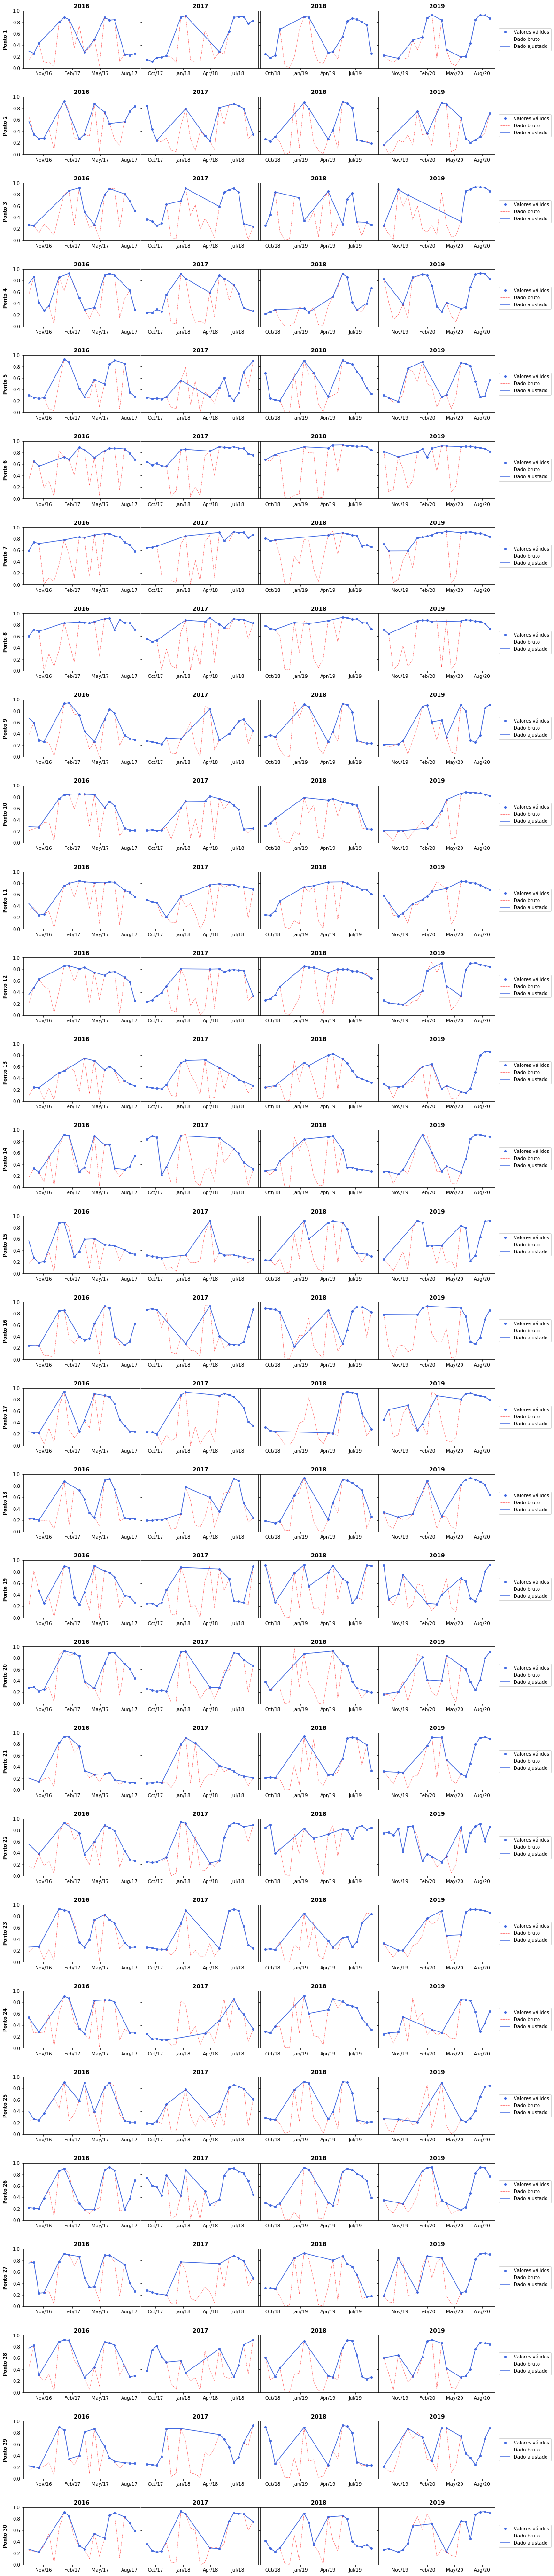

In [11]:
fig, ax = plt.subplots(df_interpolado.shape[1],len(anos_ag),figsize=(18,100),sharey=True)
fig.subplots_adjust(wspace = .015,hspace=.5)

for linha in range(df_interpolado.shape[1]):
    ponto = linha + 1
    for (coluna,ano), intervalo in zip(enumerate(anos_ag),anos_ag.values()):
        
        ax[linha,coluna].set_ylim(0,1)

        months = mdates.MonthLocator(interval=3)
        month_fmt = mdates.DateFormatter('%b/%y')

        ax[linha,coluna].get_xaxis().set_major_locator(months)
        ax[linha,coluna].get_xaxis().set_major_formatter(month_fmt)

        ax[linha,coluna].set_title(ano,weight='bold')

        ax[linha,coluna].plot(df_filtrado.loc[intervalo[0]:intervalo[1],ponto],marker='.',lw=0, mec='royalblue', mfc='royalblue', ms=8, label='Valores válidos');
        ax[linha,coluna].plot(df.loc[intervalo[0]:intervalo[1],ponto],lw=.5, color='r', ls='-.', label='Dado bruto');
        ax[linha,coluna].plot(df_interpolado.loc[intervalo[0]:intervalo[1],ponto], label='Dado ajustado', color='royalblue');

    ax[linha,0].set_ylabel('Ponto {}'.format(ponto),labelpad=10,weight='bold')
    ax[linha,3].legend(bbox_to_anchor=(1.5, .5), loc='center right');